# Logistic Regression

## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('hate_speech_training.csv')
df_train_2 = pd.read_csv('hate_speech_training_2.csv')
df_train_3 = pd.read_csv('hate_speech_training_3.csv')
df_train_4 = pd.read_csv('hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Clean Up

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [36]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Pipeline for TF-IDF on Logistic Regression

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
tfidf_lr_pipe = Pipeline([
 ('tfidf', TfidfVectorizer()),
 ('SMOTE', SMOTE(n_jobs = -1)),
 ('lr', LogisticRegression())
])

In [40]:
tfidf_lr_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression())])

In [19]:
import numpy as np
tfidf_lr_params = {
    'tfidf__max_features':[None, 27_000, 10_000],
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'lr__C': np.logspace(-3, 3, 3),
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [46]:
gs_tfidf_lr = GridSearchCV(tfidf_lr_pipe,
                            param_grid=tfidf_lr_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [47]:
gs_tfidf_lr.fit(token_docs, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'lr__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [48]:
gs_tfidf_lr.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression(C=0.001))])

In [49]:
gs_tfidf_lr.best_score_

0.9201751258697967

In [50]:
gs_tfidf_lr.best_params_

{'SMOTE__sampling_strategy': 'auto',
 'lr__C': 0.001,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (2, 2)}

## Pipeline For Best Logistic Regression Model w/TFIDF

In [53]:
tfidf_best_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (2,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 'auto')),
    ('lr', LogisticRegression(C = .001))
])

In [54]:
tfidf_best_lr_pipe.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression(C=0.001))])

In [55]:
tfidf_best_lr_pipe.score(token_docs, y_train)

0.9602323098912631

In [21]:
from sklearn.model_selection import cross_val_score

In [57]:
cross_val_score(tfidf_best_lr_pipe, token_docs, y_train, cv = 5)

array([0.92121212, 0.9209336 , 0.92328569, 0.92174778, 0.9206622 ])

In [58]:
tfidf_best_lr_pipe.score(test_token_docs, y_test)

0.9235055724417427

In [22]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

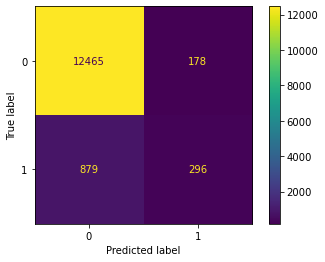

In [60]:
plot_confusion_matrix(tfidf_best_lr_pipe, test_token_docs, y_test)

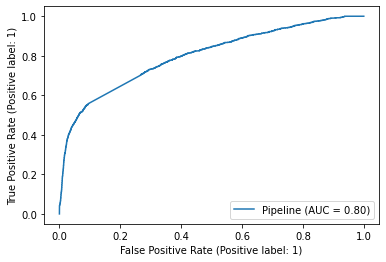

In [61]:
plot_roc_curve(tfidf_best_lr_pipe, test_token_docs, y_test)

In [62]:
y_hat = tfidf_best_lr_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12643
           1       0.62      0.25      0.36      1175

    accuracy                           0.92     13818
   macro avg       0.78      0.62      0.66     13818
weighted avg       0.91      0.92      0.91     13818



## Grid Search Pipeline for Logistic Regression on Count Vectorizer

In [63]:
cv_lr_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('lr', LogisticRegression())
])

In [64]:
cv_lr_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression())])

In [23]:
cv_lr_params = {
    'cv__max_features':[None, 27_000, 10_000],
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'cv__binary':[False, True],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'lr__C': np.logspace(-3, 3, 3),
    'lr__penalty': ['l1', 'l2'],
}

In [66]:
gs_cv_lr = GridSearchCV(cv_lr_pipe,
                            param_grid=cv_lr_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [67]:
gs_cv_lr.fit(token_docs, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__binary': [False, True],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'lr__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'lr__penalty': ['l1', 'l2']},
             verbose=1)

In [68]:
gs_cv_lr.best_score_

0.9188181834258901

In [69]:
gs_cv_lr.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(binary=True, max_features=10000,
                                 ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=0.001))])

In [70]:
gs_cv_lr.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'cv__binary': True,
 'cv__max_features': 10000,
 'cv__ngram_range': (2, 2),
 'lr__C': 0.001,
 'lr__penalty': 'l2'}

## Best Possible Logistic Regression Model for Count Vectorizer

In [71]:
cv_best_lr_pipe = Pipeline([
    ('cv', CountVectorizer(max_features = 10_000, ngram_range = (2,2),
                          binary = True)),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('lr', LogisticRegression(C = 0.001, penalty = 'l2'))
])

In [72]:
cv_best_lr_pipe.fit(token_docs, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(binary=True, max_features=10000,
                                 ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=0.001))])

In [73]:
cv_best_lr_pipe.score(token_docs, y_train)

0.9195418935789111

In [74]:
cross_val_score(cv_best_lr_pipe, token_docs, y_train, cv = 5)

array([0.91904116, 0.91812918, 0.91812918, 0.91966709, 0.91930523])

In [75]:
cv_best_lr_pipe.score(test_token_docs, y_test)

0.9181502388189319

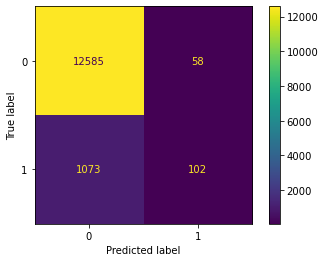

In [76]:
plot_confusion_matrix(cv_best_lr_pipe, test_token_docs, y_test)

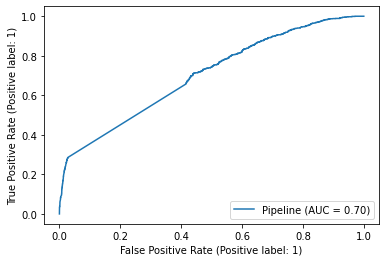

In [77]:
plot_roc_curve(cv_best_lr_pipe, test_token_docs, y_test)

In [78]:
y_hat_2 = cv_best_lr_pipe.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.64      0.09      0.15      1175

    accuracy                           0.92     13818
   macro avg       0.78      0.54      0.55     13818
weighted avg       0.90      0.92      0.89     13818



## NLP Clean-Up including ONLY language

In [25]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [26]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## Grid Search Pipelin for TFIDF/Logistic Regression

In [35]:
tfidf_lr_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('lr', LogisticRegression())
])

In [27]:
tfidf_lr_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression())])

In [28]:
gs_tfidf_lr_2 = GridSearchCV(tfidf_lr_pipe_2,
                            param_grid=tfidf_lr_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [29]:
gs_tfidf_lr_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'lr__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [30]:
gs_tfidf_lr_2.best_score_

0.9227804311643365

In [31]:
gs_tfidf_lr_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=1000.0))])

In [32]:
gs_tfidf_lr_2.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'lr__C': 1000.0,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2)}

## Best Logistic Regression Model with TFIDF

In [34]:
tfidf_best_lr_pipe_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (1,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('lr', LogisticRegression(C = 1000))
])

In [36]:
tfidf_best_lr_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=1000))])

In [37]:
tfidf_best_lr_pipe_2.score(token_docs_2, y_train)

0.9990229957844078

In [39]:
cross_val_score(tfidf_best_lr_pipe_2, token_docs_2, y_train, cv = 5)

array([0.91949344, 0.92735661, 0.92057174, 0.92364755, 0.9191243 ])

In [40]:
tfidf_best_lr_pipe_2.score(test_token_docs_2, y_test)

0.9235055724417427

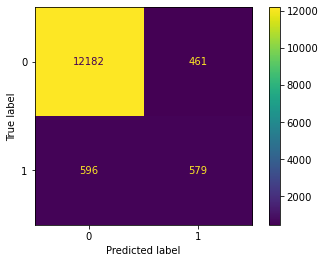

In [41]:
plot_confusion_matrix(tfidf_best_lr_pipe_2, test_token_docs_2, y_test)

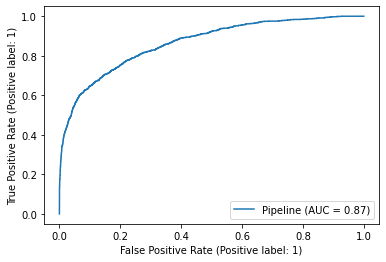

In [42]:
plot_roc_curve(tfidf_best_lr_pipe_2, test_token_docs_2, y_test)

In [44]:
y_hat_3 = tfidf_best_lr_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12643
           1       0.56      0.49      0.52      1175

    accuracy                           0.92     13818
   macro avg       0.76      0.73      0.74     13818
weighted avg       0.92      0.92      0.92     13818



## Grid Search Pipeline on Count Vectorizer with Logistic Regression

In [24]:
cv_lr_pipe_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('lr', LogisticRegression())
])

In [27]:
cv_lr_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('lr', LogisticRegression())])

In [28]:
gs_cv_lr_2 = GridSearchCV(cv_lr_pipe_2,
                            param_grid=cv_lr_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [29]:
gs_cv_lr_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__binary': [False, True],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'lr__C': array([1.e-03, 1.e+00, 1.e+03]),
                         'lr__penalty': ['l1', 'l2']},
             verbose=1)

In [30]:
gs_cv_lr_2.best_score_

0.9203922398819521

In [31]:
gs_cv_lr_2.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(binary=True, max_features=27000,
                                 ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=0.001))])

In [32]:
gs_cv_lr_2.best_params_

{'SMOTE__sampling_strategy': 0.9,
 'cv__binary': True,
 'cv__max_features': 27000,
 'cv__ngram_range': (2, 2),
 'lr__C': 0.001,
 'lr__penalty': 'l2'}

## Best Logistic Regression Model with Count Vectorizer

In [34]:
cv_best_lr_pipe_2 = Pipeline([
    ('cv', CountVectorizer(max_features = 27000, ngram_range = (2,2), binary = True)),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.9)),
    ('lr', LogisticRegression(C = 0.001, penalty = 'l2'))
])

In [35]:
cv_best_lr_pipe_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(binary=True, max_features=27000,
                                 ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.9)),
                ('lr', LogisticRegression(C=0.001))])

In [36]:
cv_best_lr_pipe_2.score(token_docs_2, y_train)

0.9208988438783449

In [37]:
cross_val_score(cv_best_lr_pipe_2, token_docs_2, y_train, cv = 5)

array([0.92057892, 0.92002895, 0.9191243 , 0.92039081, 0.92048127])

In [38]:
cv_best_lr_pipe_2.score(test_token_docs_2, y_test)

0.9197423650311188

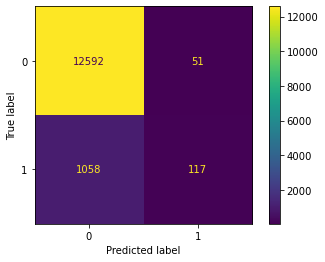

In [39]:
plot_confusion_matrix(cv_best_lr_pipe_2, test_token_docs_2, y_test)

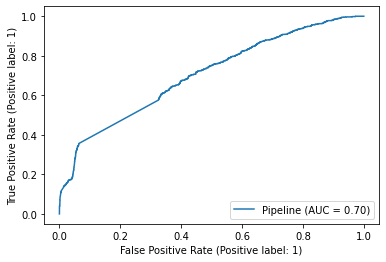

In [40]:
plot_roc_curve(cv_best_lr_pipe_2, test_token_docs_2, y_test)

In [41]:
y_hat_4 = cv_best_lr_pipe_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.70      0.10      0.17      1175

    accuracy                           0.92     13818
   macro avg       0.81      0.55      0.57     13818
weighted avg       0.90      0.92      0.89     13818

